# San Francisco Rental Prices Dashboard

In this notebook, you will compile the visualizations from the previous analysis into functions that can be used for a Panel dashboard.

In [67]:
# imports
import panel as pn
import plotly.express as px
import pandas as pd
import matplotlib.pyplot as plt
import os
from pathlib import Path
from dotenv import load_dotenv

In [68]:
pn.extension('plotly')

In [69]:
# Import hvplot.pandas after pn.extension
# This avoids plotly initialization failure
import hvplot.pandas

In [70]:
# Read the Mapbox API key
load_dotenv()
map_box_api = os.getenv("MAPBOX_TOKEN")
# Set token using Plotly Express set function
px.set_mapbox_access_token(map_box_api)

# Import Data

In [71]:
# Import the CSVs to Pandas DataFrames
sfo_data_path = Path("C:/Users/Squid Ink Tony/Jupyter-Workspace/sfo_neighborhoods_census_data.csv")
sfo_data = pd.read_csv(sfo_data_path, index_col="year")

locations_path = Path("C:/Users/Squid Ink Tony/Jupyter-Workspace/neighborhoods_coordinates.csv")
df_neighborhood_locations = pd.read_csv(locations_path)

In [72]:
figHousingUnits = sfo_data['housing_units'].groupby('year').mean()
salesRent = sfo_data[['sale_price_sqr_foot', 'gross_rent']].groupby('year').mean()
salesRent = sfo_data[['sale_price_sqr_foot', 'gross_rent']].groupby('year').mean()
sfoDF = sfo_data.groupby(['year', 'neighborhood']).mean()
mostExpensive = sfo_data.groupby('neighborhood').mean().sort_values(ascending=False, by='sale_price_sqr_foot')
mostExpensive2 = mostExpensive.reset_index().round(decimals=2)

- - -

## Panel Visualizations

In this section, you will copy the code for each plot type from your analysis notebook and place it into separate functions that Panel can use to create panes for the dashboard. 

These functions will convert the plot object to a Panel pane.

Be sure to include any DataFrame transformation/manipulation code required along with the plotting code.

Return a Panel pane object from each function that can be used to build the dashboard.

Note: Remove any `.show()` lines from the code. We want to return the plots instead of showing them. The Panel dashboard will then display the plots.

In [73]:
# Define Panel Visualization Functions
def housing_units_per_year():
    """Housing Units Per Year."""
    minUnits = min(figHousingUnits)
    maxUnits = max(figHousingUnits)
    stdUnits = figHousingUnits.std()
    
    housingPlot = plt.bar(
    figHousingUnits.index,
    figHousingUnits,
)
    plt.ylim(
        (minUnits - stdUnits),
        (maxUnits + stdUnits)
)
    plt.suptitle(
        'Housing Units in San Francisco from 2010 to 2016',
        weight='bold'
)
    plt.xlabel('Year')
    plt.ylabel('Housing Units')
           
    return housingPlot

def average_gross_rent():
    """Average Gross Rent in San Francisco Per Year."""
    grossRentPlot = plt.plot(
                salesRent.index, 
                salesRent['gross_rent']
            )
    plt.xlim(
        salesRent.index[0],
        salesRent.index[-1]
    )
    plt.suptitle(
        'Average Gross Rent in San Francisco',
        weight='bold'
        
    )
    plt.xlabel('Year')
    plt.ylabel('Gross Rent')
    
    return grossRentPlot


def average_sales_price():
    """Average Sales Price Per Year."""   
    salesPlot = plt.plot(
        salesRent.index,
        salesRent['sale_price_sqr_foot']
    )
    plt.xlim(
        salesRent.index[0],
        salesRent.index[-1]
    )
    plt.suptitle(
        'Average Sale Price per Square Foot in San Francisco',
        weight='bold'
       )
    plt.xlabel('Year')
    plt.ylabel('Avg. Sale Price')
    
    return salesPlot

def average_price_by_neighborhood():
    """Average Prices by Neighborhood."""
    priceNeighborhoodPlot = sfoDF['sale_price_sqr_foot'].hvplot(
        xlabel='year',
        ylabel='average sale per square foot',
        label=' ',
        groupby='neighborhood',
        height=300,
        width=450
    )
    
    return priceNeighborhoodPlot

def top_most_expensive_neighborhoods():
    """Top 10 Most Expensive Neighborhoods."""    
    mostExpensivePlot = mostExpensive['sale_price_sqr_foot'].head(10).hvplot.bar(
        ylabel='average sale price per square foot',
        xlabel='neighborhood',
        label='top 10 most expensive neighborhoods',
        rot=40,
        height=400,
        width=650,
    )
    
    return mostExpensivePlot

def parallel_coordinates():
    """Parallel Coordinates Plot."""
    coordinatesPlot = px.parallel_coordinates(
        mostExpensive.head(10),
        color='sale_price_sqr_foot'
    )
    
    return coordinatesPlot

def parallel_categories():
    """Parallel Categories Plot.""" 
    categoriesPlot = px.parallel_categories(
        mostExpensive2.head(10),
        color='sale_price_sqr_foot'
    )
    
    return categoriesPlot

def neighborhood_map():
    """Neighborhood Map"""
    
    neighborhoodCombined = mostExpensive2.join(
        df_neighborhood_locations.set_index('Neighborhood'),
        how='inner',
        on='neighborhood'
    )
    
    neigborhoodPlot = px.scatter_mapbox(
        neighborhoodCombined,
        lat="Lat",
        lon="Lon",
        size="gross_rent",
        color="neighborhood",
        zoom=10,
        title='neighborhoods by gross rent',
        height=800,
        width=1000,
    )
    
    return neigborhoodPlot

def neighborhood_map2():
    """Neighborhood Map"""
    
    neighborhoodCombined = mostExpensive2.join(
        df_neighborhood_locations.set_index('Neighborhood'),
        how='inner',
        on='neighborhood'
    )
    
    neigborhoodPlot = px.scatter_mapbox(
        neighborhoodCombined,
        lat="Lat",
        lon="Lon",
        size="sale_price_sqr_foot",
        color="neighborhood",
        zoom=10,
        title='neighborhoods by average sale price per square foot',
        height=800,
        width=1000,
    )
    
    return neigborhoodPlot

## Panel Dashboard

In this section, you will combine all of the plots into a single dashboard view using Panel. Be creative with your dashboard design!

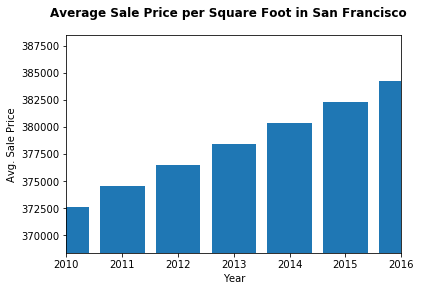

In [74]:
sf_market_plots = pn.Column(
    '## San Francisco housing market overview',
    housing_units_per_year(),
    average_gross_rent(),
    average_sales_price(),
)

neighborhood_plots = pn.Column(
    '## San Francisco neighborhoods overview',
    average_price_by_neighborhood(),
    top_most_expensive_neighborhoods(),
    )

parallel_plots = pn.Column(
    '## Parallel plots',
    parallel_categories(),
    parallel_coordinates(),
)

neighborhood_maps = pn.Column(
    '## Neighborhood maps',
    neighborhood_map(),
    neighborhood_map2(),
)

dashboard = pn.Tabs(
    ('Housing market', sf_market_plots),
    ('Neighborhoods', neighborhood_plots),
    ('Parallels', parallel_plots),
    ('Neighborhood maps', neighborhood_maps),
)

## Serve the Panel Dashboard

In [75]:
dashboard.servable(0)

Tabs
    [0] Column
        [0] Markdown(str)
        [1] Str(BarContainer)
        [2] Str(list)
        [3] Str(list)
    [1] Column
        [0] Markdown(str)
        [1] Row
            [0] HoloViews(DynamicMap)
            [1] Column
                [0] WidgetBox
                    [0] Select(margin=(20, 20, 20, 20), name='neighborhood', options=['Alamo Square', ...], value='Alamo Square', width=250)
                [1] VSpacer()
        [2] HoloViews(Bars)
    [2] Column
        [0] Markdown(str)
        [1] Plotly(Figure)
        [2] Plotly(Figure)
    [3] Column
        [0] Markdown(str)
        [1] Plotly(Figure)
        [2] Plotly(Figure)